In [108]:
import numpy as np
from numpy import random as rnd
from matplotlib import pyplot as plt
import warnings,datetime,os,time,math

import torch
import pandas as pd
import seaborn as sns

from keras.layers import Activation,Dense,LSTM,Dropout,BatchNormalization,Concatenate,Input
from keras.models import Model,Sequential

from itertools import product

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import pickle,h5py,json

import urllib
from bs4 import BeautifulSoup
from lmfit import Model as lmmodel

sns.set()

In [3]:
rootpath = '..\\..\\TF_data\\STOCKDATA\\Data\\DJIA\\'

In [4]:
df_dj = pd.read_csv(rootpath+'DJIA\\DJIA.csv',index_col='DATE',parse_dates=['DATE'])

df_dj['DJIA'] = df_dj['DJIA'].apply(lambda x: np.nan if x=='.' else float(x))
df_dj = df_dj.resample('MS').mean()

In [5]:
df = pd.read_csv(rootpath+'DJIA30\\all_stocks_2006-01-01_to_2018-01-01.csv',index_col='Date',parse_dates=['Date'])

df = df[['Open']].reset_index(drop=False).groupby('Date').mean().rename(columns={'Open':'0_AVG'})
df = df.resample('MS').mean()

In [6]:
date_min = max(df.index.min(),df_dj.index.min())
date_max = min(df.index.max(),df_dj.index.max())

In [7]:
df_dj = df_dj[date_min:date_max]
df = df[date_min:date_max]

In [8]:
for filename in os.listdir(rootpath+'DJIA30\\'):
    if filename.split('_')[0]=='all': continue
    cf = pd.read_csv(rootpath+'DJIA30\\'+filename,index_col='Date',parse_dates=['Date'])
    cf = cf[['Open']].reset_index(drop=False).groupby('Date').mean().rename(columns={'Open':filename.split('_')[0]})
    df[filename.split('_')[0]] = cf.resample('MS').mean()[date_min:date_max]

In [9]:
df['0_DJIA'] = df_dj

In [10]:
df = df[df.columns.sort_values()]

In [11]:
dfX = df.copy().drop(columns=['0_DJIA','0_AVG'])

In [12]:
dfY = pd.DataFrame(index=df.index)

In [13]:
for colname in dfX.columns.tolist():
    tf = df[['0_AVG',colname]].diff(periods=3)
    tf['delta'] = tf[['0_AVG',colname]].apply(lambda x: 0 if x[1]-x[0]<0 or np.isnan(x[0]) or np.isnan(x[1]) else 1,axis=1)
    dfY[colname] = tf['delta']

In [14]:
dfY.iloc[:3] = np.nan

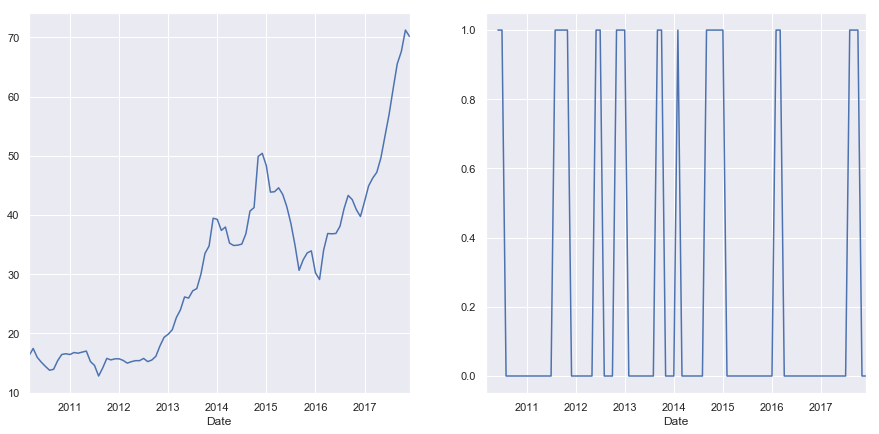

In [22]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,7))

dfX['AABA'].plot(ax=ax[0])
dfY['AABA'].plot(ax=ax[1])

plt.show()

In [23]:
lookback = 15

X = []
y = []

for colname in dfX.columns.tolist():
    for k in range(lookback,dfX.shape[0]):
        X.append(np.array([dfX[colname].values[k-lookback:k],df['0_DJIA'].values[k-lookback:k],df['0_AVG'].values[k-lookback:k]]))
        y.append(dfY[colname].values[k])

X = np.stack(X,axis=0).reshape(-1,lookback,3)
y = np.stack(y,axis=0).reshape(-1,1)

ohe = pp.OneHotEncoder()
y_ohe = ohe.fit_transform(y)

In [72]:
X0,X1,y0,y1 = train_test_split(X,y_ohe,test_size=0.2,shuffle=True)

In [73]:
input_layer = Input(shape=(lookback,3,))
lstm_layer = LSTM(units=128,activation='relu')(input_layer)
dense_layer = Dense(units=64,activation='relu')(lstm_layer)
output_layer = Dense(units=2,activation='softmax')(dense_layer)

model = Model(inputs=input_layer,outputs=output_layer)

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['mse'])
model.fit(X0,y0,batch_size=5,epochs=3,verbose=2)

model.evaluate(X1,y1)

In [109]:
pca = PCA()
pca_dec = pca.fit_transform(X.reshape(-1,15*3))

print(pca.explained_variance_ratio_[:3])

[0.95363217 0.02360261 0.00673828]


In [120]:
t = pd.DataFrame()
t['PCA0'] = pca_dec[:,0] 
t['PCA1'] = pca_dec[:,1]

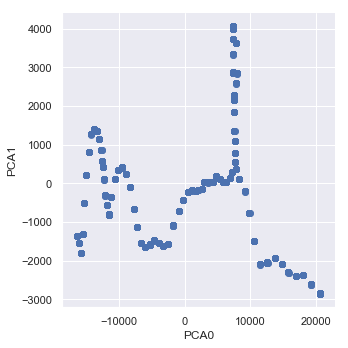

In [122]:
sns.lmplot(x='PCA0',y='PCA1',data=t,fit_reg=False)

In [116]:
t

,0,1
0,-16400.847630,0.0
1,-16064.856008,0.0
2,-15678.719843,1.0
3,-15496.860505,1.0
4,-15271.577736,1.0
...,...,...
2444,15768.305496,0.0
2445,16861.132671,0.0
2446,18000.982776,1.0
2447,19230.230072,0.0
